## Appendix A 

In [199]:
using PyPlot
using LinearAlgebra 
using Random

In [200]:
# Sample time [s]
T = 0.05;

# Set the length of the simulation to run [s]
simtime = 40;

# Compute the number of samples needed (and make sure it is an integer)
N = convert(Int,ceil(simtime/T))+1;

## Vehicle Model

In [201]:
# Kinematic Model
# Key Variables for the model
l=3.40 #m
b=4.32 #
M= 5 #of pseudolites
function vehicle(q,u,T)
    l=3.40 #m
    b=4.32
    q[1] += T*((u[1]+u[2])*0.5*cos(q[3]) - ((u[1]-u[2])/l*b*sin(q[3])));
    q[2] += T*((u[1]+u[2])*0.5*sin(q[3]) + ((u[1]-u[2])/l*b*cos(q[3])));
    q[3] += T*((u[1]-u[2])/l)
    return q;
end

vehicle (generic function with 1 method)

In [202]:
# Make some open loop inputs
function openloop(t,T)
 [(cos(15*T*t)); sign(cos(0.1*T*t))];
end

openloop (generic function with 1 method)

In [203]:
# Let's Define Variables
# We begin with q 
q=[0.0 0.0 0.0]
# We will need to store the values of q[1],q[2],q[3] in an arrays:
x=zeros(N)
y=zeros(N)
θ = zeros(N)
t = zeros(N)    # Time counter for our open loop function
# We are also going to want to initialize our sensors here to obtain data from the vehicle path simulation
u_meas = zeros(2,N)
z = zeros(M,N);
d = zeros(M,N);
# We next will initialize our pseudolite array 
p = zeros(2,M);

In [204]:
# Let's generate some pseudolite positions randomly within 300m
for i = 1:M
    p[:,i]=[300*rand(), 300*rand()];
end 

In [205]:
# Since we are going to be conducting our measurements we nee our Q and R values
sigma_v=0.025 # This STD Deve applies to both track encoders 
sigma_w= 0.8
Q = [sigma_v^2 0; 0 sigma_v^2];
R = (sigma_w)*Matrix(1.0I,M,M); 

In [206]:
# Now we generate our vehicle simulation and our sensor measurements
# Need to assigne t a value of 1

for i = 1:N-1   
    
    q= vehicle(q,openloop(t[i],T),T); #Here we will take the three coordinates for q 
   
    
    # We want to find the Euclidean distance between a given pseudolite and the drive
    for j = 1:M
        d[j,i] = sqrt((q[1]-(b*cos(q[3]))-p[1,j])^2 + (q[2]-(b*sin(q[3]))-p[2,j])^2);
    end
    
    z[:,i]= d[:,i] + sqrt(R)*randn(5,1); 
    
    u_meas[:,i] = openloop(t[i],T) + sqrt(Q)*randn(2,1);
    
    # Now before we loop through we need to export the values store in q
 
    x[i]=q[1]
    y[i]=q[2]
    θ[i]=q[3]
    t[i+1] = t[i] + T # We use the t counter to plot time vs. error later on
end

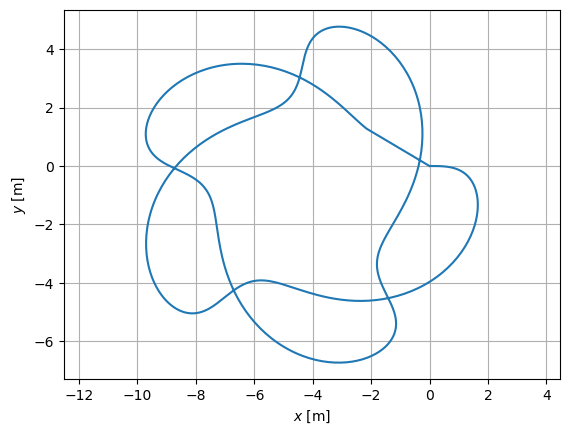

In [207]:
# Make an x-y plot of the vehicle path
plot(x,y,"-");
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
grid("on");
axis("equal"); # This line makes sure the axes are square, and thus the trajectory as the proper scale

In [208]:
# It's now time to develop our EKF, we begin by intitializing our guess variables
q̂ = zeros(N,3);
P = zeros(3,3,N);

In [209]:
# Make a guess at the initial state (try playing with this)
q̂[1,:] = [1;-1;0];
P[:,:,1] = [1 0 0; 0 1 0; 0 0 0]; 

In [210]:
# Create some static matrices
m = Matrix(1.0I,M,M); 

# Initialize our dynamic matrices
G = zeros(3,2);
F = zeros(3,3);
L = zeros(3,2);
K = zeros(3,M);
C = zeros(M,3)
H = zeros(M,3)
xpb = zeros(M); # The following are to help with the length of the equation for C 
ypb = zeros(M); # They will effectively be the distance from each pseudolite to b in the x and y direction
h = zeros(M);

In [211]:
# Time for the dynamic matrices
# Run the EKF on the measurements
for i in 1:N-1
   for j in 1:M
       
        xpb[j] = q̂[i,1]-b*cos(q̂[i,3])-p[1,j];
        ypb[j] = q̂[i,2]-b*sin(q̂[i,3])-p[2,j];
        
        C[j,:] = [xpb[j]/sqrt(xpb[j]^2+ypb[j]^2)   ypb[j]/sqrt(xpb[j]^2+ypb[j]^2)   (xpb[j]*b*sin(q̂[i,3])-ypb[j]*b*cos(q̂[i,3]))/sqrt(xpb[j]^2+ypb[j]^2)]
        H=C
        h[j] = sqrt((q̂[i,1]-b*cos(q̂[i,3])-p[1,j])^2+(q̂[i,2]-b*sin(q̂[i,3])-p[2,j])^2)
    end
    # Create the dynamic matrices
    G = [cos(q̂[i,3])/2-b*sin(q̂[i,3])/l  cos(q̂[i,3])/2+b*sin(q̂[i,3])/l; sin(q̂[i,3])/2+b*cos(q̂[i,3])/l sin(q̂[i,3])/2-b*cos(q̂[i,3])/l ;1/l -1/l];          
    F = Matrix(1.0I,3,3) + T*[0 0 (-sin(q̂[i,3])/2*u_meas[1,i]-b*cos(q̂[i,3])/l*u_meas[1,i]-sin(q̂[i,3])/2*u_meas[2,i]+b*cos(q̂[i,3])/l*u_meas[2,i]); 0 0 (cos(q̂[i,3])/2*u_meas[1,i] - b*sin(q̂[i,3])/l*u_meas[1,i] + cos(q̂[i,3])/2*u_meas[2,i] + b*sin(q̂[i,3])/l*u_meas[2,i]); 0 0 0]
    L = T*G;
    
    # Compute the a priori estimate
    P[:,:,i+1] = F*P[:,:,i]*F' + L*Q*L';
    q̂[i+1,:] = q̂[i,:] + T*G*u_meas[:,i];
    
    # Compute the a posteriori estimate
    K = P[:,:,i+1]*H'*inv(H*P[:,:,i+1]*H' + m*R*m');
    q̂[i+1,:] =  q̂[i+1,:] + K*(z[:,i+1] - h);
    P[:,:,i+1] = (Matrix(1.0I,3,3) - K*H)*P[:,:,i+1];
    
    
end

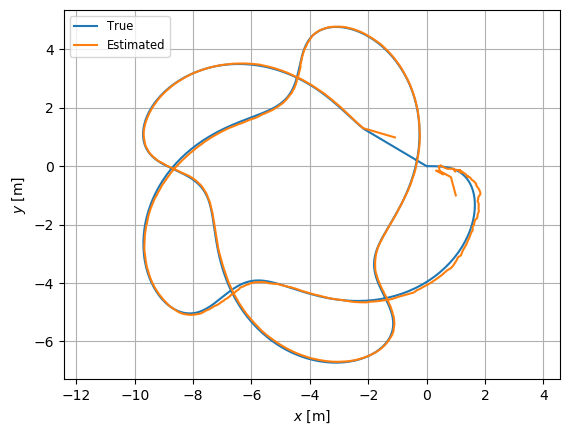

In [212]:
# Make an x-y plot of the true and estimated vehicle paths
plot(x,y,"-");
plot(q̂[:,1],q̂[:,2],"-"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["True","Estimated"])
grid("on");
axis("equal");

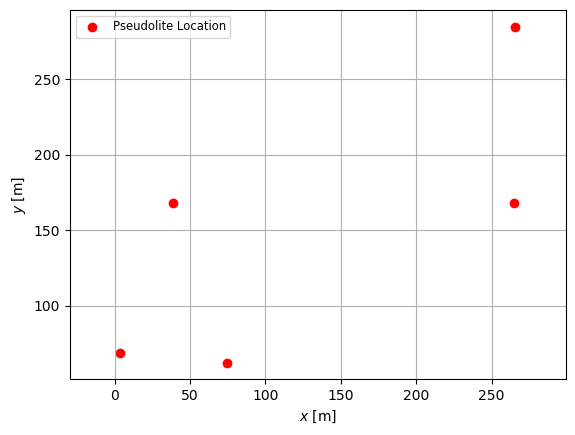

In [213]:
# These are positions of our randomly distributed pseudolites for m=5
scatter(p[1,:], p[2,:], color = "red"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["Pseudolite Location"])
grid("on");
axis("equal");        

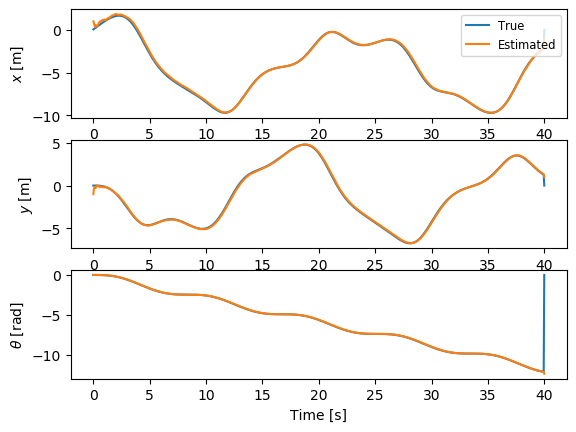

In [214]:
# x-component
subplot(3,1,1);
plot(t,x); #plotting the x-component of the true state of the system
plot(t,q̂[:,1]); #plotting the x-component of the estimated state of the system
legend(loc="upper right",fontsize="small",["True","Estimated"])
ylabel(L"$x$ [m]");

# y-component
subplot(3,1,2);
plot(t,y); #plotting the y-component of the true state of the system
plot(t,q̂[:,2]); #plotting the y-component of the estimated state of the system
ylabel(L"$y$ [m]");

# theta-component
subplot(3,1,3);
plot(t,θ); #plotting the theta-component of the true state of the system
plot(t,q̂[:,3]); #plotting the theta-component of the estimated state of the system
ylabel(L"$\theta$ [rad]");
xlabel("Time [s]");

In [215]:
# For ease of import into the graphs we have assigned variables J,O,B to hold the difference between our estimated and real values
J= zeros(N);
O =zeros(N);
B = zeros(N);
J= x-q̂[:,1];
O = y-q̂[:,2];
B = θ-q̂[:,3];

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[216]:7
└ @ Core In[216]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[216]:16
└ @ Core In[216]:16


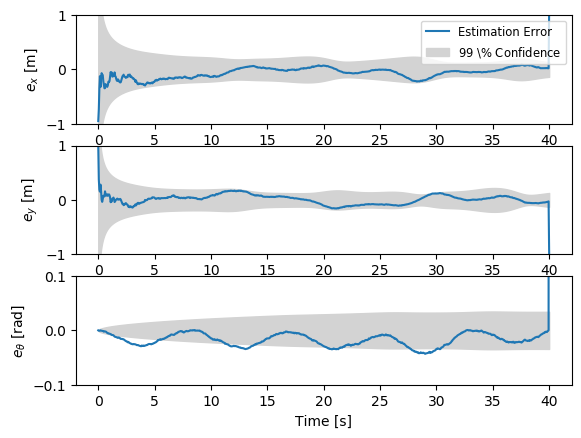

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[216]:24
└ @ Core In[216]:24


In [216]:
# Make plots of the errors and confidence bounds over time
sigma = zeros(3,N);

# x-component
subplot(3,1,1);
sigma[1,:] = sqrt.(P[1,1,:]);
plt[:fill_between](t,reshape(-3*sigma[1,:],N),reshape(3*sigma[1,:],N),color="lightgrey")
plot(t,J);
ylim(-1,1)
ylabel(L"$e_x$ [m]");
legend(loc="upper right",fontsize="small",["Estimation Error",L"$99$ \% Confidence"])

# y-component
subplot(3,1,2);
sigma[2,:] = sqrt.(P[2,2,:]);
plt[:fill_between](t,reshape(-3*sigma[2,:],N),reshape(3*sigma[2,:],N),color="lightgrey")
plot(t,O);
ylim(-1,1)
ylabel(L"$e_y$ [m]");

# theta-component
subplot(3,1,3);
sigma[3,:] = sqrt.(P[3,3,:]);
plt[:fill_between](t,reshape(-3*sigma[3,:],N),reshape(3*sigma[3,:],N),color="lightgrey")
plot(t,B);
ylim(-0.1,0.1)
ylabel(L"$e_{\theta}$ [rad]");
xlabel("Time [s]");

## Attempting Different Pseudolite Numbers

In [217]:
# We begin with an attempt for m=1

In [218]:
# Kinematic model for our model
# Key Variables for the model
l=3.40 #m
b=4.32 #
M= 1 #of pseudolites
function vehicle(q,u,T)
    l=3.40 #m
    b=4.32
    q[1] += T*((u[1]+u[2])*0.5*cos(q[3]) - ((u[1]-u[2])/l*b*sin(q[3])));
    q[2] += T*((u[1]+u[2])*0.5*sin(q[3]) + ((u[1]-u[2])/l*b*cos(q[3])));
    q[3] += T*((u[1]-u[2])/l)
    return q;
end

vehicle (generic function with 1 method)

In [219]:
# Make some open loop inputs

function openloop(t,T)
 [(cos(15*T*t)); sign(cos(0.1*T*t))];
end

openloop (generic function with 1 method)

In [220]:
# Let's Define Variables
# We begin with q 
q=[0.0 0.0 0.0]
# We will need to store the values of q[1],q[2],q[3] in an arrays:
x=zeros(N)
y=zeros(N)
θ = zeros(N)
t = zeros(N)    # Time counter for our open loop function
# We are also going to want to initialize our sensors here to obtain data from the vehicle path simulation
u_meas = zeros(2,N)
z = zeros(M,N);
d = zeros(M,N);
# We next will initialize our pseudolite array 
p = zeros(2,M);

In [221]:
# Let's generate some pseudolite positions randomly within 300m
for i = 1:M
    p[:,i]=[300*rand(), 300*rand()];
end 

In [222]:
# Since we are going to be conducting our measurements we nee our Q and R values
sigma_v=0.025 # This applies to both track encoders 
sigma_w= 0.8
Q = [sigma_v^2 0; 0 sigma_v^2];
R = (sigma_w)*Matrix(1.0I,M,M); 

In [223]:
# Now we generate our vehicle simulation and our sensor measurements
for i = 1:N-1   
    
    q= vehicle(q,openloop(t[i],T),T); #Here we will take the three coordinates for q 
   
    
    # We want to find the euclidean distance between a given 
    for j = 1:M
        d[j,i] = sqrt((q[1]-(b*cos(q[3]))-p[1,j])^2 + (q[2]-(b*sin(q[3]))-p[2,j])^2);
    end
    
    z[:,i]= d[:,i] + sqrt(R)*randn(M,1); 
    
    u_meas[:,i] = openloop(t[i],T) + sqrt(Q)*randn(2,1);
    # Now before we loop through we need to export the values store in q
 
    x[i]=q[1]
    y[i]=q[2]
    θ[i]=q[3]
    t[i+1] = t[i] + T
end

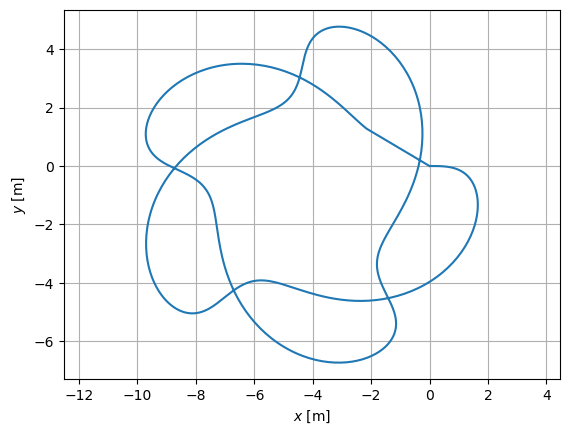

In [224]:
# Make an x-y plot of the vehicle path
plot(x,y,"-");
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
grid("on");
axis("equal"); # This line makes sure the axes are square, and thus the trajectory as the proper scale

In [225]:
# It's now time to develop our EKF, we begin by intitializing our guess variables
q̂ = zeros(N,3);
P = zeros(3,3,N);

In [226]:
# Make a guess at the initial state (try playing with this)
q̂[1,:] = [1;-1;0];
P[:,:,1] = [1 0 0; 0 1 0; 0 0 0]; # We will guys this value 

In [227]:
# Create some static matrices

m = Matrix(1.0I,M,M);

# Initialize some static matrices
G = zeros(3,2);
F = zeros(3,3);
L = zeros(3,2);
K = zeros(3,M);
C = zeros(M,3)
H = zeros(M,3)
xpb = zeros(M); # The following are to help with the length of the equation for C 
ypb = zeros(M); # They will effectively be the distance from each pseudolite to b in the x and y direction
h = zeros(M);

In [228]:
# Time for the dynamic matrices


# Run the EKF on the measurements
for i in 1:N-1
   for j in 1:M
       
        xpb[j] = q̂[i,1]-b*cos(q̂[i,3])-p[1,j];
        ypb[j] = q̂[i,2]-b*sin(q̂[i,3])-p[2,j];
        
        C[j,:] = [xpb[j]/sqrt(xpb[j]^2+ypb[j]^2)   ypb[j]/sqrt(xpb[j]^2+ypb[j]^2)   (xpb[j]*b*sin(q̂[i,3])-ypb[j]*b*cos(q̂[i,3]))/sqrt(xpb[j]^2+ypb[j]^2)]
        H=C
        h[j] = sqrt((q̂[i,1]-b*cos(q̂[i,3])-p[1,j])^2+(q̂[i,2]-b*sin(q̂[i,3])-p[2,j])^2)
    end
    # Create the dynamic matrices
    G = [cos(q̂[i,3])/2-b*sin(q̂[i,3])/l  cos(q̂[i,3])/2+b*sin(q̂[i,3])/l; sin(q̂[i,3])/2+b*cos(q̂[i,3])/l sin(q̂[i,3])/2-b*cos(q̂[i,3])/l ;1/l -1/l];          
    F = Matrix(1.0I,3,3) + T*[0 0 (-sin(q̂[i,3])/2*u_meas[1,i]-b*cos(q̂[i,3])/l*u_meas[1,i]-sin(q̂[i,3])/2*u_meas[2,i]+b*cos(q̂[i,3])/l*u_meas[2,i]); 0 0 (cos(q̂[i,3])/2*u_meas[1,i] - b*sin(q̂[i,3])/l*u_meas[1,i] + cos(q̂[i,3])/2*u_meas[2,i] + b*sin(q̂[i,3])/l*u_meas[2,i]); 0 0 0]
    L = T*G;
    
    # Compute the a priori estimate
    P[:,:,i+1] = F*P[:,:,i]*F' + L*Q*L';
    q̂[i+1,:] = q̂[i,:] + T*G*u_meas[:,i];
    
    # Compute the a posteriori estimate
    K = P[:,:,i+1]*H'*inv(H*P[:,:,i+1]*H' + m*R*m');
    q̂[i+1,:] =  q̂[i+1,:] + K*(z[:,i+1] - h);
    P[:,:,i+1] = (Matrix(1.0I,3,3) - K*H)*P[:,:,i+1];
    
    
end

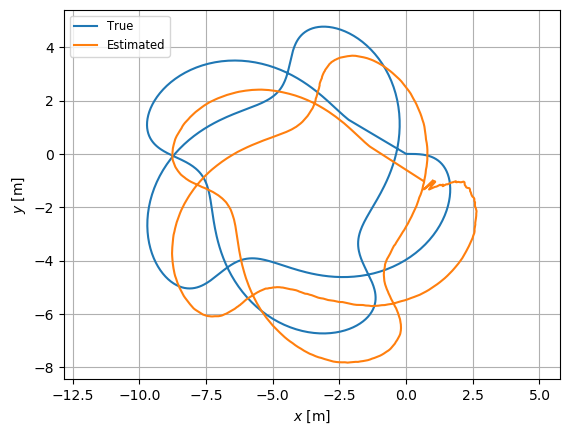

In [229]:
# Make an x-y plot of the true and estimated vehicle paths
plot(x,y,"-");
plot(q̂[:,1],q̂[:,2],"-"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["True","Estimated"])
grid("on");
axis("equal");

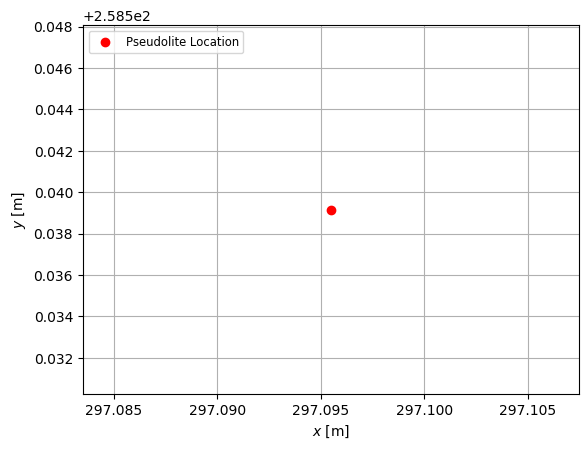

In [230]:
scatter(p[1,:], p[2,:], color = "red"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["Pseudolite Location"])
grid("on");
axis("equal");        

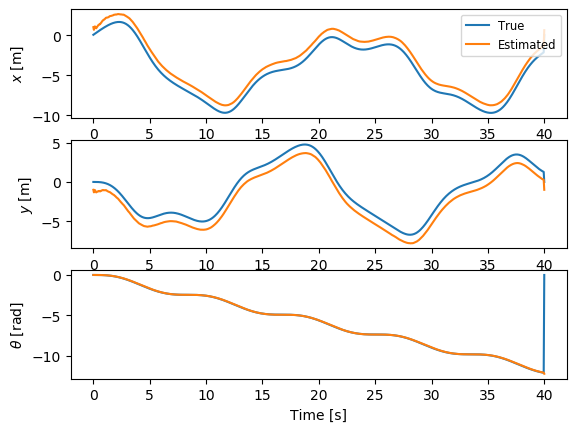

In [231]:
# x-component
subplot(3,1,1);
plot(t,x); #plotting the x-component of the true state of the system
plot(t,q̂[:,1]); #plotting the x-component of the estimated state of the system
legend(loc="upper right",fontsize="small",["True","Estimated"])
ylabel(L"$x$ [m]");

# y-component
subplot(3,1,2);
plot(t,y); #plotting the y-component of the true state of the system
plot(t,q̂[:,2]); #plotting the y-component of the estimated state of the system
ylabel(L"$y$ [m]");

# theta-component
subplot(3,1,3);
plot(t,θ); #plotting the theta-component of the true state of the system
plot(t,q̂[:,3]); #plotting the theta-component of the estimated state of the system
ylabel(L"$\theta$ [rad]");
xlabel("Time [s]");

In [232]:
J= zeros(N);
O =zeros(N);
B = zeros(N);
J= x-q̂[:,1];
O = y-q̂[:,2];
B = θ-q̂[:,3];

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[233]:7
└ @ Core In[233]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[233]:16
└ @ Core In[233]:16


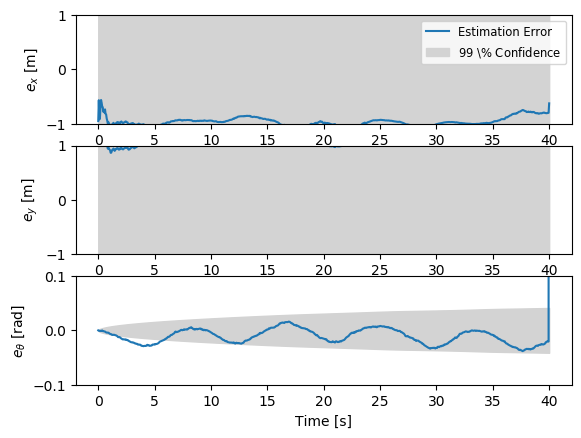

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[233]:24
└ @ Core In[233]:24


In [233]:
# Make plots of the errors and confidence bounds over time
sigma = zeros(3,N);

# x-component
subplot(3,1,1);
sigma[1,:] = sqrt.(P[1,1,:]);
plt[:fill_between](t,reshape(-3*sigma[1,:],N),reshape(3*sigma[1,:],N),color="lightgrey")
plot(t,J);
ylim(-1,1)
ylabel(L"$e_x$ [m]");
legend(loc="upper right",fontsize="small",["Estimation Error",L"$99$ \% Confidence"])

# y-component
subplot(3,1,2);
sigma[2,:] = sqrt.(P[2,2,:]);
plt[:fill_between](t,reshape(-3*sigma[2,:],N),reshape(3*sigma[2,:],N),color="lightgrey")
plot(t,O);
ylim(-1,1)
ylabel(L"$e_y$ [m]");

# theta-component
subplot(3,1,3);
sigma[3,:] = sqrt.(P[3,3,:]);
plt[:fill_between](t,reshape(-3*sigma[3,:],N),reshape(3*sigma[3,:],N),color="lightgrey")
plot(t,B);
ylim(-0.1,0.1)
ylabel(L"$e_{\theta}$ [rad]");
xlabel("Time [s]");

In [ ]:
# Attempt with 10 Pseudolites 

In [234]:
# Kinematic model for our model

# Key Variables for the model
l=3.40 #m
b=4.32 #
M= 5 #of pseudolites
function vehicle(q,u,T)
    l=3.40 #m
    b=4.32
    q[1] += T*((u[1]+u[2])*0.5*cos(q[3]) - ((u[1]-u[2])/l*b*sin(q[3])));
    q[2] += T*((u[1]+u[2])*0.5*sin(q[3]) + ((u[1]-u[2])/l*b*cos(q[3])));
    q[3] += T*((u[1]-u[2])/l)
    return q;
end

vehicle (generic function with 1 method)

In [235]:
# Make some open loop inputs

function openloop(t,T)
 [(cos(15*T*t)); sign(cos(0.1*T*t))];
end

openloop (generic function with 1 method)

In [236]:
# Let's Define Variables
# We begin with q 
q=[0.0 0.0 0.0]
# We will need to store the values of q[1],q[2],q[3] in an arrays:
x=zeros(N)
y=zeros(N)
θ = zeros(N)
t = zeros(N)    # Time counter for our open loop function
# We are also going to want to initialize our sensors here to obtain data from the vehicle path simulation
u_meas = zeros(2,N)
z = zeros(M,N);
d = zeros(M,N);
# We next will initialize our pseudolite array 
p = zeros(2,M);

In [237]:
# Let's generate some pseudolite positions randomly within 300m
for i = 1:M
    p[:,i]=[300*rand(), 300*rand()];
end 

In [238]:
# Since we are going to be conducting our measurements we nee our Q and R values
sigma_v=0.025 # This applies to both track encoders 
sigma_w= 0.8
Q = [sigma_v^2 0; 0 sigma_v^2];
R = (sigma_w)*Matrix(1.0I,M,M); 

In [239]:
# Now we generate our vehicle simulation and our sensor measurements


for i = 1:N-1   
    
    q= vehicle(q,openloop(t[i],T),T); #Here we will take the three coordinates for q 
   
    
    # We want to find the euclidean distance between a given 
    for j = 1:M
        d[j,i] = sqrt((q[1]-(b*cos(q[3]))-p[1,j])^2 + (q[2]-(b*sin(q[3]))-p[2,j])^2);
    end
    
    z[:,i]= d[:,i] + sqrt(R)*randn(5,1); 
    
    u_meas[:,i] = openloop(t[i],T) + sqrt(Q)*randn(2,1);
    # Now before we loop through we need to export the values store in q
 
    x[i]=q[1]
    y[i]=q[2]
    θ[i]=q[3]
    t[i+1] = t[i] + T
end

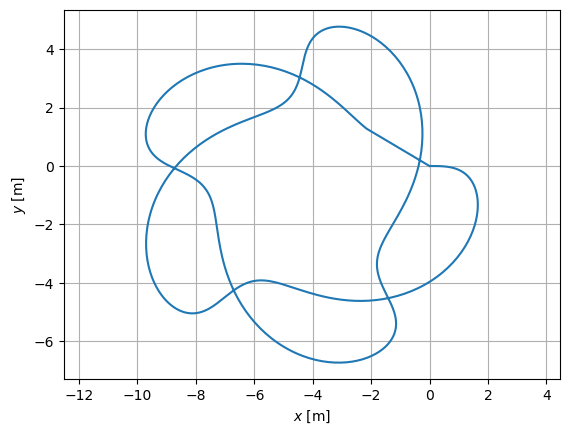

In [240]:
# Make an x-y plot of the vehicle path
plot(x,y,"-");
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
grid("on");
axis("equal"); # This line makes sure the axes are square, and thus the trajectory as the proper scale

In [241]:
# It's now time to develop our EKF, we begin by intitializing our guess variables
q̂ = zeros(N,3);
P = zeros(3,3,N);

In [242]:
# Make a guess at the initial state (try playing with this)
q̂[1,:] = [1;-1;0];
P[:,:,1] = [1 0 0; 0 1 0; 0 0 0]; # We will guys this value 

In [243]:
# Create some static matrices

m = Matrix(1.0I,M,M);

# Initialize some static matrices
G = zeros(3,2);
F = zeros(3,3);
L = zeros(3,2);
K = zeros(3,M);
C = zeros(M,3)
H = zeros(M,3)
xpb = zeros(M); # The following are to help with the length of the equation for C 
ypb = zeros(M); # They will effectively be the distance from each pseudolite to b in the x and y direction
h = zeros(M);

In [244]:
# Time for the dynamic matrices


# Run the EKF on the measurements
for i in 1:N-1
   for j in 1:M
       
        xpb[j] = q̂[i,1]-b*cos(q̂[i,3])-p[1,j];
        ypb[j] = q̂[i,2]-b*sin(q̂[i,3])-p[2,j];
        
        C[j,:] = [xpb[j]/sqrt(xpb[j]^2+ypb[j]^2)   ypb[j]/sqrt(xpb[j]^2+ypb[j]^2)   (xpb[j]*b*sin(q̂[i,3])-ypb[j]*b*cos(q̂[i,3]))/sqrt(xpb[j]^2+ypb[j]^2)]
        H=C
        h[j] = sqrt((q̂[i,1]-b*cos(q̂[i,3])-p[1,j])^2+(q̂[i,2]-b*sin(q̂[i,3])-p[2,j])^2)
    end
    # Create the dynamic matrices
    G = [cos(q̂[i,3])/2-b*sin(q̂[i,3])/l  cos(q̂[i,3])/2+b*sin(q̂[i,3])/l; sin(q̂[i,3])/2+b*cos(q̂[i,3])/l sin(q̂[i,3])/2-b*cos(q̂[i,3])/l ;1/l -1/l];          
    F = Matrix(1.0I,3,3) + T*[0 0 (-sin(q̂[i,3])/2*u_meas[1,i]-b*cos(q̂[i,3])/l*u_meas[1,i]-sin(q̂[i,3])/2*u_meas[2,i]+b*cos(q̂[i,3])/l*u_meas[2,i]); 0 0 (cos(q̂[i,3])/2*u_meas[1,i] - b*sin(q̂[i,3])/l*u_meas[1,i] + cos(q̂[i,3])/2*u_meas[2,i] + b*sin(q̂[i,3])/l*u_meas[2,i]); 0 0 0]
    L = T*G;
    
    # Compute the a priori estimate
    P[:,:,i+1] = F*P[:,:,i]*F' + L*Q*L';
    q̂[i+1,:] = q̂[i,:] + T*G*u_meas[:,i];
    
    # Compute the a posteriori estimate
    K = P[:,:,i+1]*H'*inv(H*P[:,:,i+1]*H' + m*R*m');
    q̂[i+1,:] =  q̂[i+1,:] + K*(z[:,i+1] - h);
    P[:,:,i+1] = (Matrix(1.0I,3,3) - K*H)*P[:,:,i+1];
    
    
end

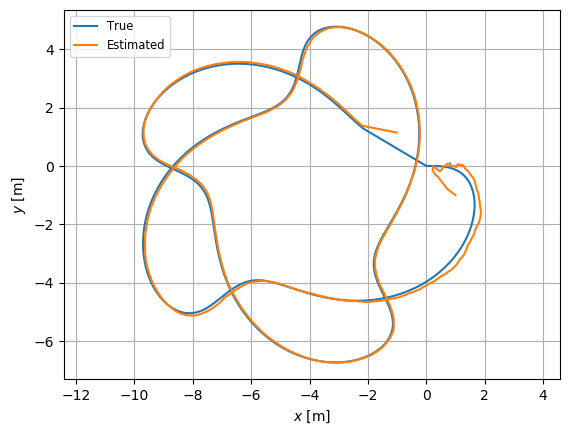

In [245]:
# Make an x-y plot of the true and estimated vehicle paths
plot(x,y,"-");
plot(q̂[:,1],q̂[:,2],"-"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["True","Estimated"])
grid("on");
axis("equal");

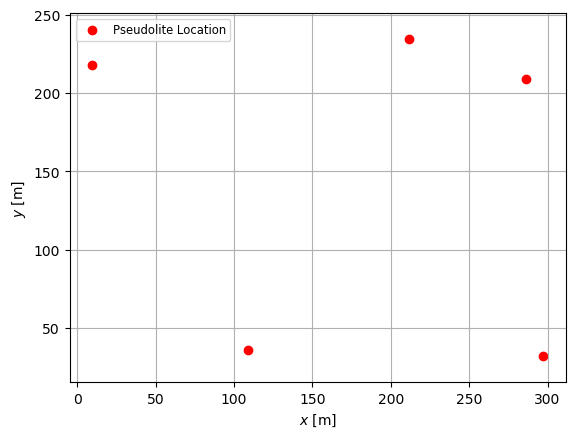

In [246]:
scatter(p[1,:], p[2,:], color = "red"); 
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["Pseudolite Location"])
grid("on");
axis("equal");        

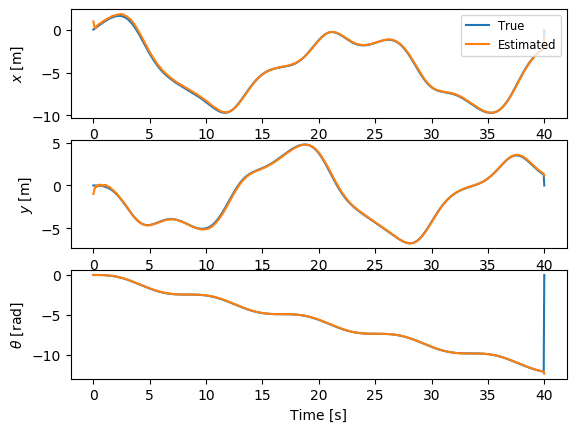

In [247]:
# x-component
subplot(3,1,1);
plot(t,x); #plotting the x-component of the true state of the system
plot(t,q̂[:,1]); #plotting the x-component of the estimated state of the system
legend(loc="upper right",fontsize="small",["True","Estimated"])
ylabel(L"$x$ [m]");

# y-component
subplot(3,1,2);
plot(t,y); #plotting the y-component of the true state of the system
plot(t,q̂[:,2]); #plotting the y-component of the estimated state of the system
ylabel(L"$y$ [m]");

# theta-component
subplot(3,1,3);
plot(t,θ); #plotting the theta-component of the true state of the system
plot(t,q̂[:,3]); #plotting the theta-component of the estimated state of the system
ylabel(L"$\theta$ [rad]");
xlabel("Time [s]");

In [248]:
J= zeros(N);
O =zeros(N);
B = zeros(N);
J= x-q̂[:,1];
O = y-q̂[:,2];
B = θ-q̂[:,3];

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[249]:7
└ @ Core In[249]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[249]:16
└ @ Core In[249]:16


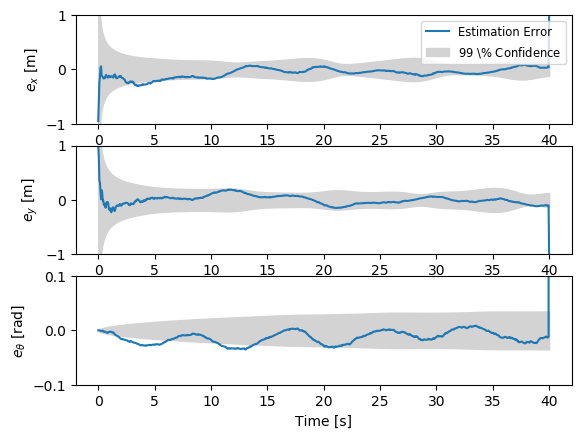

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[249]:24
└ @ Core In[249]:24


In [249]:
# Make plots of the errors and confidence bounds over time
sigma = zeros(3,N);

# x-component
subplot(3,1,1);
sigma[1,:] = sqrt.(P[1,1,:]);
plt[:fill_between](t,reshape(-3*sigma[1,:],N),reshape(3*sigma[1,:],N),color="lightgrey")
plot(t,J);
ylim(-1,1)
ylabel(L"$e_x$ [m]");
legend(loc="upper right",fontsize="small",["Estimation Error",L"$99$ \% Confidence"])

# y-component
subplot(3,1,2);
sigma[2,:] = sqrt.(P[2,2,:]);
plt[:fill_between](t,reshape(-3*sigma[2,:],N),reshape(3*sigma[2,:],N),color="lightgrey")
plot(t,O);
ylim(-1,1)
ylabel(L"$e_y$ [m]");

# theta-component
subplot(3,1,3);
sigma[3,:] = sqrt.(P[3,3,:]);
plt[:fill_between](t,reshape(-3*sigma[3,:],N),reshape(3*sigma[3,:],N),color="lightgrey")
plot(t,B);
ylim(-0.1,0.1)
ylabel(L"$e_{\theta}$ [rad]");
xlabel("Time [s]");

## Control

In [137]:
## We begin our control integration by restating our control model from phase 2
# First we restate our track velocities 
uL = 2; 
uR = 2;  

In [138]:
# We also rebuild our kinematic model from part one
l=3.40 #m
b=4.32 #
M=5 #of pseudolites

function vehicle(q,u,T)
    l=3.40 #m
    b=4.32
    q[1,end] += T*((u[1]+u[2])*0.5*cos(q[3,end]) - ((u[1]-u[2])/l*b*sin(q[3,end])));
    q[2,end] += T*((u[1]+u[2])*0.5*sin(q[3,end]) + ((u[1]-u[2])/l*b*cos(q[3,end])));
    q[3,end] += T*((u[1]-u[2])/l)
    return q;
end

# In phase 2 we used the akerman function to compute our gain K and we do so again with the following functions
# Our inputs are matrices A and B as will as our desired poles pt.
function acker(A,B,pt)
    pt = -pt;
    a_2 = pt[1]*pt[2];
    a_1 = pt[1]+pt[2];
    phi = A^2 + a_1*A + a_2*Matrix(1.0*I, 2, 2);
    
    # Find controllability matrix (C is always square for m = 1)
    C = hcat(B,A*B);
    
    # Find the controller gain
    K_gain = -[0 1]*inv(C)*phi;
    return K_gain;
    
end

acker (generic function with 1 method)

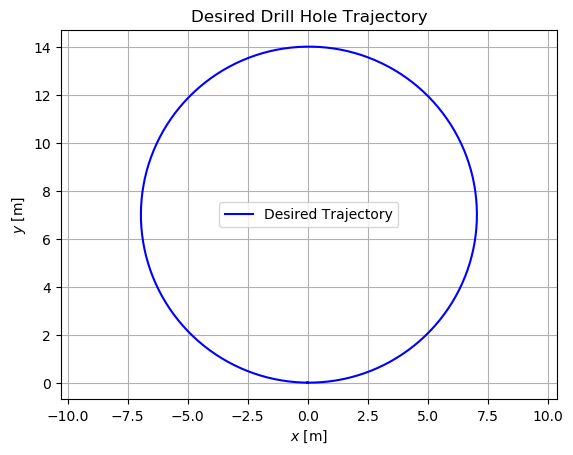

In [250]:
# We begin with our initial positon and defineing some variables
# We want to draw a circle with radius 7 so we will use a constant speed and constant angular velocity (omega)
N=2000 #Note this is an arbitrary large number in order to ensure that we iterate long enough to reach our target.
q_re = zeros(3,N); 
R = 7; 
vel= (1/2)*(uL+uR); 
omega = vel/R; 
count=1 # counter

#Initialize Variables
x_c=zeros(N)
y_c=zeros(N)
theta_c=zeros(N)



# Our desired trajectory will be to complete a full circle with radius 7: 

for u=1:(N-1)
    
       theta_dot = omega;  
       x_dot = vel*cos(q_re[3,u]); 
       y_dot = vel*sin(q_re[3,u]); 
   
 #We then index the array consider the orientation change 
       q_re[1,u+1] = q_re[1,u]+x_dot*T; 
       q_re[2,u+1] = q_re[2,u]+y_dot*T; 
       q_re[3,u+1] = q_re[3,u]+theta_dot*T; 
    
    
    count= count+1 
    if q_re[3,u+1] >= (2*pi)
    
    break
    
    end
   
end
plot(q_re[1,:],q_re[2,:],"-", Color = "blue")
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend([ "Desired Trajectory", "Desired Drill Hole Locations"])
title("Desired Drill Hole Trajectory")
grid("on");
axis("equal");


In [252]:
## Next, as in part one we design our Q and R Values
sigma_v=0.025 # This applies to both track encoders 
sigma_w= 0.8
Q = [sigma_v^2 0; 0 sigma_v^2];
R = (sigma_w)*Matrix(1.0I,M,M); 


In [253]:
## We want to begin by setting up our estimator and then we will design our corresponding controller
## We begin with Pseudolite Placement as was done in part 1
for i = 1:M
    p[:,i]=[300*rand(), 300*rand()];
end 

In [265]:
## Again just like in part one we must initialize the various arrays for measurements that we will be using:
# So, let's Define Variables
# But first we adjust our timing
N=count  #We only want to iterate as long as it took to trace the circle
t=zeros(N-1)
# We are also going to want to initialize our sensors here to obtain data from the vehicle path simulation
u_meas = zeros(2,N)
z = zeros(M,N);
d = zeros(M,N);
# We next will initialize our pseudolite array 

In [256]:
# We must define our Matrices and Arrays
q = zeros(3,N-1)
q̂ = zeros(3,N-1)
P = zeros(3,3,N-1)
m = Matrix(1.0I,M,M);
G = zeros(3,2);
F = zeros(3,3);
L = zeros(3,2);
K = zeros(3,2);
C = zeros(M,3)
H = zeros(M,3)
xpb = zeros(1,M); # As in part one, the following are to help with the length of the equation for C 
ypb = zeros(1,M); # They will effectively be the distance from each pseudolite to b in the x and y direction
h = zeros(M,1);


In [257]:
# We need the variables that we will use for our ackerman function

e = zeros(2,1);
U = [vel;vel];
q = [0.0; 0.0; 0.0]
A = [0 vel; 0 0];
B = [b; 1]; 
pt = [-0.1,-0.1]; 
K_gain = acker(A,B,pt);

In [258]:
# We now set our initial pose and our first guess estimate values
# Make a guess time
q=[0.0;0.0;0.0]
q̂[:,1] = [1.0; -1.0; 0.0];
P[:,:,1] = [1 0 0; 0 1 0; 0 0 0]; 

In [259]:
for i = 1:(N-2)
    # We start by determining our euclidean distance calculation from part 1 
    for j = 1:M
      d[j,i] = sqrt((q[1,i]-(b*cos(q[3,i]))-p[1,j])^2 + (q[2,i]-(b*sin(q[3,i]))-p[2,j])^2);
    end

    z[:,i]= d[:,i] + sqrt(R)*randn(M,1);
    
    # We now move to our controller in an attempt derive uL and uR velocity inputs for our vehicle model 
    # We first calculate the lateral error which is the difference between q and our desired path
    el=-(q[1,i]-q_re[1,i])*sin(q_re[3,i])+(q[2,i]-q_re[2,i])*cos(q_re[3,i]);
    
    # Now we calucate the heading error refering to the difference between q and our desired orientation
    
    eh = q[3,i]-q_re[3,i];
    
    # Store the values in a single arrray
    
    e = hcat(e, [el; eh]);
   
    
    # The angular velocity can then be calculated 
    w = (K_gain*e[:,i])[1];
    
    uL = vel - (w*l/2); 
    uR = vel + (w*l/2); 
    
    # Lets store these in a matrix
    
    U = hcat(U, [uL;uR])
    
    # We can now begin our vehicle simulation
    cyrus=vehicle(q[:,i],U[:,i],T)
     q = hcat(q, cyrus[1:3]);
    
    
    # These quite honestly got lost as we played with different structures for the loop but are both integral 
    u_meas[:,i] = U[:,i] + sqrt(Q)*randn(2,1);
    t[i+1] = t[i] + T
    
    # Create the dynamic matrices
   G = [cos(q̂[3,i])/2-b*sin(q̂[3,i])/l  cos(q̂[3,i])/2+b*sin(q̂[3,i])/l; sin(q̂[3,i])/2+b*cos(q̂[3,i])/l sin(q̂[3,i])/2-b*cos(q̂[3,i])/l ;1/l -1/l];          
   F = Matrix(1.0I,3,3) + T*[0 0 (-sin(q̂[3,i])/2*u_meas[1,i]-b*cos(q̂[3,i])/l*u_meas[1,i]-sin(q̂[3,i])/2*u_meas[2,i]+b*cos(q̂[3,i])/l*u_meas[2,i]); 0 0 (cos(q̂[3,i])/2*u_meas[1,i]-b*sin(q̂[3,i])/l*u_meas[1,i]+cos(q̂[3,i])/2*u_meas[2,i]+b*sin(q̂[3,i])/l*u_meas[2,i]); 0 0 0]
   L = T*G;
    
    # Compute the a priori estimate
     P[:,:,i+1] = F*P[:,:,i]*F' + L*Q*L';
     q̂[:,i+1] = q̂[:,i] + T*G*u_meas[:,i];
    
    for j = 1:M
       
       xpb[j] = q̂[1,i]-b*cos(q̂[3,i])-p[1,j];
       ypb[j] = q̂[2,i]-b*sin(q̂[3,i])-p[2,j];
        
       C[j,:] = [xpb[j]/sqrt(xpb[j]^2+ypb[j]^2)   ypb[j]/sqrt(xpb[j]^2+ypb[j]^2)   (xpb[j]*b*sin(q̂[3,i])-ypb[j]*b*cos(q̂[3,i]))/sqrt(xpb[j]^2+ypb[j]^2)]
       H=C
    h[j] = sqrt((q̂[1,i]-b*cos(q̂[3,i])-p[1,j])^2+(q̂[2,i]-b*sin(q̂[3,i])-p[2,j])^2)
     end
    
    # Compute the a posteriori estimate
  K = P[:,:,i+1]*H'*inv(H*P[:,:,i+1]*H' + m*R*m');
  q̂[:,i+1] =  q̂[:,i+1] + K*(z[:,i] - h);
  P[:,:,i+1] = (Matrix(1.0I,3,3) - K*H)*P[:,:,i+1];

end

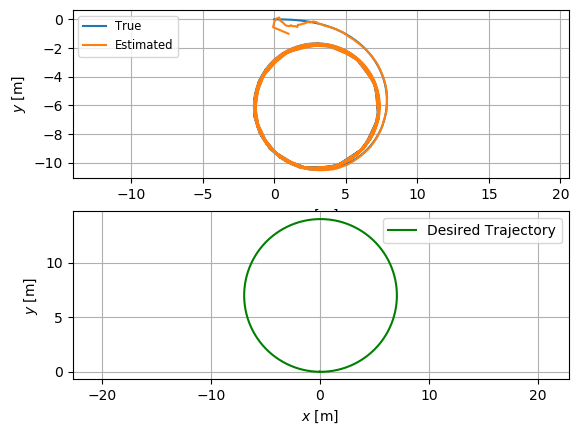

In [261]:
subplot(2,1,1)
plot(q[1,1:(N-1)],q[2,1:(N-1)],"-");
plot(q̂[1,1:(N-1)],q̂[2,1:(N-1)],"-");
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend(loc="upper left",fontsize="small",["True","Estimated"])
grid("on");
axis("equal");
subplot(2,1,2)
plot(q_re[1,:],q_re[2,:],"-", Color="green")
#scatter(xDrillPoints, yDrillPoints, color = "purple"); #drill hole locations
xlabel(L"$x$ [m]");
ylabel(L"$y$ [m]");
legend([ "Desired Trajectory"])
grid("on");
axis("equal");

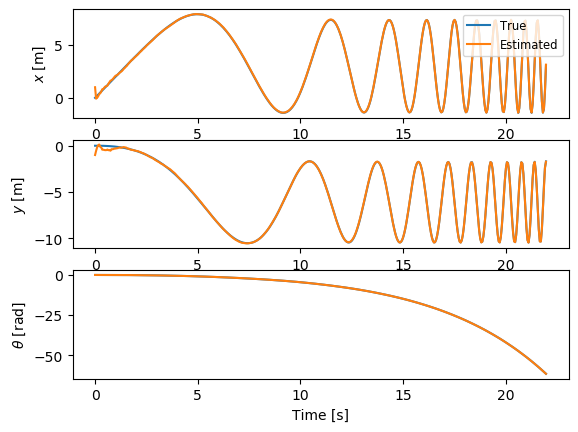

In [262]:
# x-component
subplot(3,1,1);
plot(t[1:N-1],q[1,1:(N-1)]); #plotting the x-component of the true state of the system
plot(t[1:N-1],q̂[1,1:(N-1)]); #plotting the x-component of the estimated state of the system
legend(loc="upper right",fontsize="small",["True","Estimated"])
ylabel(L"$x$ [m]");

# y-component
subplot(3,1,2);
plot(t[1:N-1],q[2,1:(N-1)]);#plotting the y-component of the true state of the system
plot(t[1:N-1],q̂[2,1:(N-1)]); #plotting the y-component of the estimated state of the system
ylabel(L"$y$ [m]");

# theta-component
subplot(3,1,3);
plot(t[1:N-1],q[3,1:(N-1)]);; #plotting the theta-component of the true state of the system
plot(t[1:N-1],q̂[3,1:(N-1)]); #plotting the theta-component of the estimated state of the system
ylabel(L"$\theta$ [rad]");
xlabel("Time [s]");

In [263]:
J= zeros(1,N-1);
O =zeros(1,N-1);
B = zeros(N-1,1);
J= q[1,1:(N-1)]-q̂[1,1:(N-1)];
O = q[2,1:(N-1)]-q̂[2,1:(N-1)];
B = q[3,1:(N-1)]-q̂[3,1:(N-1)];

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[264]:7
└ @ Core In[264]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[264]:16
└ @ Core In[264]:16


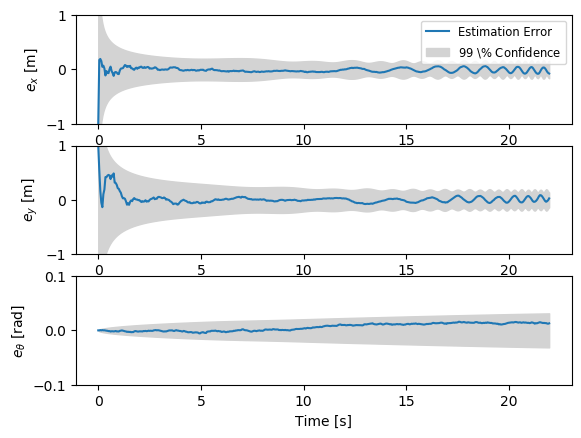

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[264]:24
└ @ Core In[264]:24


In [264]:
# Make plots of the errors and confidence bounds over time
sigma = zeros(3,N-1);

# x-component
subplot(3,1,1);
sigma[1,:] = sqrt.(P[1,1,:]);
plt[:fill_between](t[1:N-1],reshape(-3*sigma[1,:],(N-1)),reshape(3*sigma[1,:],(N-1)),color="lightgrey")
plot(t[1:N-1],J);
ylim(-1,1)
ylabel(L"$e_x$ [m]");
legend(loc="upper right",fontsize="small",["Estimation Error",L"$99$ \% Confidence"])

# y-component
subplot(3,1,2);
sigma[2,:] = sqrt.(P[2,2,:]);
plt[:fill_between](t[1:N-1],reshape(-3*sigma[2,:],(N-1)),reshape(3*sigma[2,:],(N-1)),color="lightgrey")
plot(t[1:N-1],O);
ylim(-1,1)
ylabel(L"$e_y$ [m]");

# theta-component
subplot(3,1,3);
sigma[3,:] = sqrt.(P[3,3,:]);
plt[:fill_between](t[1:N-1],reshape(-3*sigma[3,:],(N-1)),reshape(3*sigma[3,:],(N-1)),color="lightgrey")
plot(t[1:N-1],B);
ylim(-0.1,0.1)
ylabel(L"$e_{\theta}$ [rad]");
xlabel("Time [s]");